In [ ]:
import yearly_data_preprocessing
import importlib
importlib.reload(yearly_data_preprocessing)
import pickle

# Load the sampled songs from the pickle file
# This file should contain a list of sampled songs from the year 2024 generated by the `ground_truth.py`
with open(r'./sampled_songs_20_from_2024.pkl', 'rb') as f:
    sampled_songs = pickle.load(f)

In [ ]:
from llama_cpp import Llama
# ---------------- Llama model initialization ----------------
llm = Llama(
    model_path="./gemma-2b-it.Q4_K_M.gguf",
    # n_gpu_layers=35,# or 0 for CPU-only
    n_gpu_layers=35,
    n_ctx=8192, # maximum prompt + response tokens
    # use_mlock=True,          # optional: prevent swap
    verbose=False,
)

# ---------------- Context window size ----------------
# 'gemma.context_length' = Max tokens the model supports (prompt + output)
# This is the maximum number of tokens the model can process at once.

# n_ctx (in llama-cpp)	The number of tokens you allow during inference. It controls maximum prompt + response tokens
print("Context window size (n_ctx):", llm.n_ctx())

Context window size (n_ctx): 8192


In [ ]:

# ---------------- Function to analyze lyrics ----------------
def get_avg_positivity_score(tags: list) -> float:
    """
    Calculate the average positivity score based on the provided tags.
    
    Args:
        tags (list): A list of tags representing emotions.
        
    Returns:
        float: The average positivity score.
    """
    positivity_dict = {
    'Joyful': 5, 'Melancholic': 2, 'Hopeful': 5, 'Angry': 1, 'Romantic': 4,
    'Nostalgic': 3, 'Sad': 1, 'Energetic': 4, 'Passionate': 4, 'Lonely': 1,
    'Uplifting': 5, 'Bittersweet': 3, 'Empowering': 5, 'Heartbroken': 1,
    'Reflective': 3, 'Playful': 4, 'Dark': 1, 'Calm': 4, 'Longing': 2, 'Triumphant': 5
    }
    scores = [positivity_dict.get(tag, 0) for tag in tags]
    valid_scores = [score for score in scores if score > 0]
    
    if valid_scores:
        return sum(valid_scores) / len(valid_scores)
    else:
        return 0.0
    
from typing import List, Tuple
# Function to analyze lyrics and return tags and average positivity score
# The function takes a string of lyrics as input and returns a tuple containing a list of emotion tags and the average positivity score.
def from_lyrics_to_positivity(lyrics: str) -> Tuple[List[str], float]:
    """
    Analyze the lyrics and return the average positivity score.
    
    Args:
        lyrics (str): The lyrics to analyze.
        
    Returns:
        float: The average positivity score of the lyrics.
    """
    prompt = """
        You are an expert in analyzing song lyrics to determine the emotions they convey.
        Analyze the following song lyrics and return exactly 3 emotion tags that best summarize the emotions conveyed by the song. Only output the tags, in this format: #tag1 #tag2 #tag3.
        The tags must be adjectives and strictly chosen from the following list: Joyful, Melancholic, Hopeful, Angry, Romantic, Nostalgic, Sad, Energetic, Passionate, Lonely, Uplifting, Bittersweet, Empowering, Heartbroken, Reflective, Playful, Dark, Calm, Longing, Triumphant
    '''{lyrics}'''
    """
    # along with weights assigning to each each tag that summing up to 100%
    response = llm(prompt.format(lyrics=lyrics), temperature=0.0, max_tokens=512, stop={"\n\n\n"})
    mood = response['choices'][0]['text'].strip().split('\n')
    # print(response, "\n************\n")
    # print(mood[0])
    tags_str = mood[0] if mood else ''
    tags = [tag.lstrip('#') for tag in tags_str.strip().split()]
    
    return tags, get_avg_positivity_score(tags)

In [ ]:
# ---------------- Analyze sampled songs ----------------
# Iterate through the sampled songs and analyze their lyrics to get mood tags and positivity scores
for song in sampled_songs:
    song.mood_tags_local, song.positivity_score_local = from_lyrics_to_positivity(song.lyrics)
print(sampled_songs[0])

SongEntry(album='The Drug In Me Is You', artist='Falling In Reverse', duration=219.0, first_occurrence_in_week=True, lyrics='I heard a knock upon my door the other day\nI opened it to find death staring in my face\nThe feel of mortal stalking still reverberates\nEverywhere I go, I drag this coffin just in case\n\nMy body\'s trembling, sends shivers down my spine\nAdrenaline kicks in, shifts into overdrive\nYour secrets keep you sick, your lies keep you alive\nSnake eyes every single time you roll with crooked dice\n\nI felt the darkness as it tried to pull me down\nThe kind of dark that haunts a hundred-year-old house\nWell, I wrestle with my thoughts, I shook the hand of doubt\nRunning from my past, I\'m praying, "Feet, don\'t fail me now"\n\nI\'ve lost my goddamn mind, it happens all the time\nI can\'t believe I\'m actually meant to be here\nTrying to consume, the drug in me is you\nAnd I\'m so high on misery, can\'t you see?\n\nI got these questions always running through my head\nS

In [ ]:
# ---------------- Prepare a list of the sampled songs only with the neccessary fields for ground truth vs. local LLM comparison. ----------------
lst_sample_20 = [{'title': song.title,
  'artist': song.artist,
  # 'lyrics': song.lyrics,
  'mood_tags': song.mood_tags,
  'positivity_score':song.positivity_score,
  'mood_tags_local': song.mood_tags_local,  
  'positivity_score_local': song.positivity_score_local
  } for song in sampled_songs]

In [ ]:
# Save the sampled songs with their mood tags and positivity scores to a pickle file
with open("compare_sampled_songs_20_from_2024.pkl", "wb") as f:
    pickle.dump(sampled_songs, f)
with open("compare_sampled_songs_20_from_2024_abbr.pkl", "wb") as f:
    pickle.dump(lst_sample_20, f)


In [ ]:
lst_sample_20

[{'title': 'The Drug In Me Is You',
  'artist': 'Falling In Reverse',
  'mood_tags': ['Dark', 'Melancholic', 'Reflective'],
  'positivity_score': 2.0,
  'mood_tags_local': ['Angry', 'Dark', 'Nostalgia'],
  'positivity_score_local': 1.0},
 {'title': 'Sirens (feat. Sophie Powers)',
  'artist': 'MOTHICA',
  'mood_tags': ['Energetic', 'Dark', 'Passionate'],
  'positivity_score': 3.0,
  'mood_tags_local': ['Energetic', 'Hopeful', 'Dark'],
  'positivity_score_local': 3.3333333333333335},
 {'title': 'Cigaro',
  'artist': 'System Of A Down',
  'mood_tags': ['Energetic', 'Playful', 'Empowering'],
  'positivity_score': 4.333333333333333,
  'mood_tags_local': ['Angry', 'Energetic', 'Bittersweet'],
  'positivity_score_local': 2.6666666666666665},
 {'title': 'KILL ALL PREDATORS',
  'artist': 'Banshee',
  'mood_tags': ['Angry', 'Dark', 'Energetic'],
  'positivity_score': 2.0,
  'mood_tags_local': ['Angry', 'Dark', 'Energetic'],
  'positivity_score_local': 2.0},
 {'title': 'they’re all around us',
  

In [ ]:
import pickle
with open('./compare_sampled_songs_20_from_2024_abbr.pkl', 'rb') as f:
    campare_sample20 = pickle.load(f)

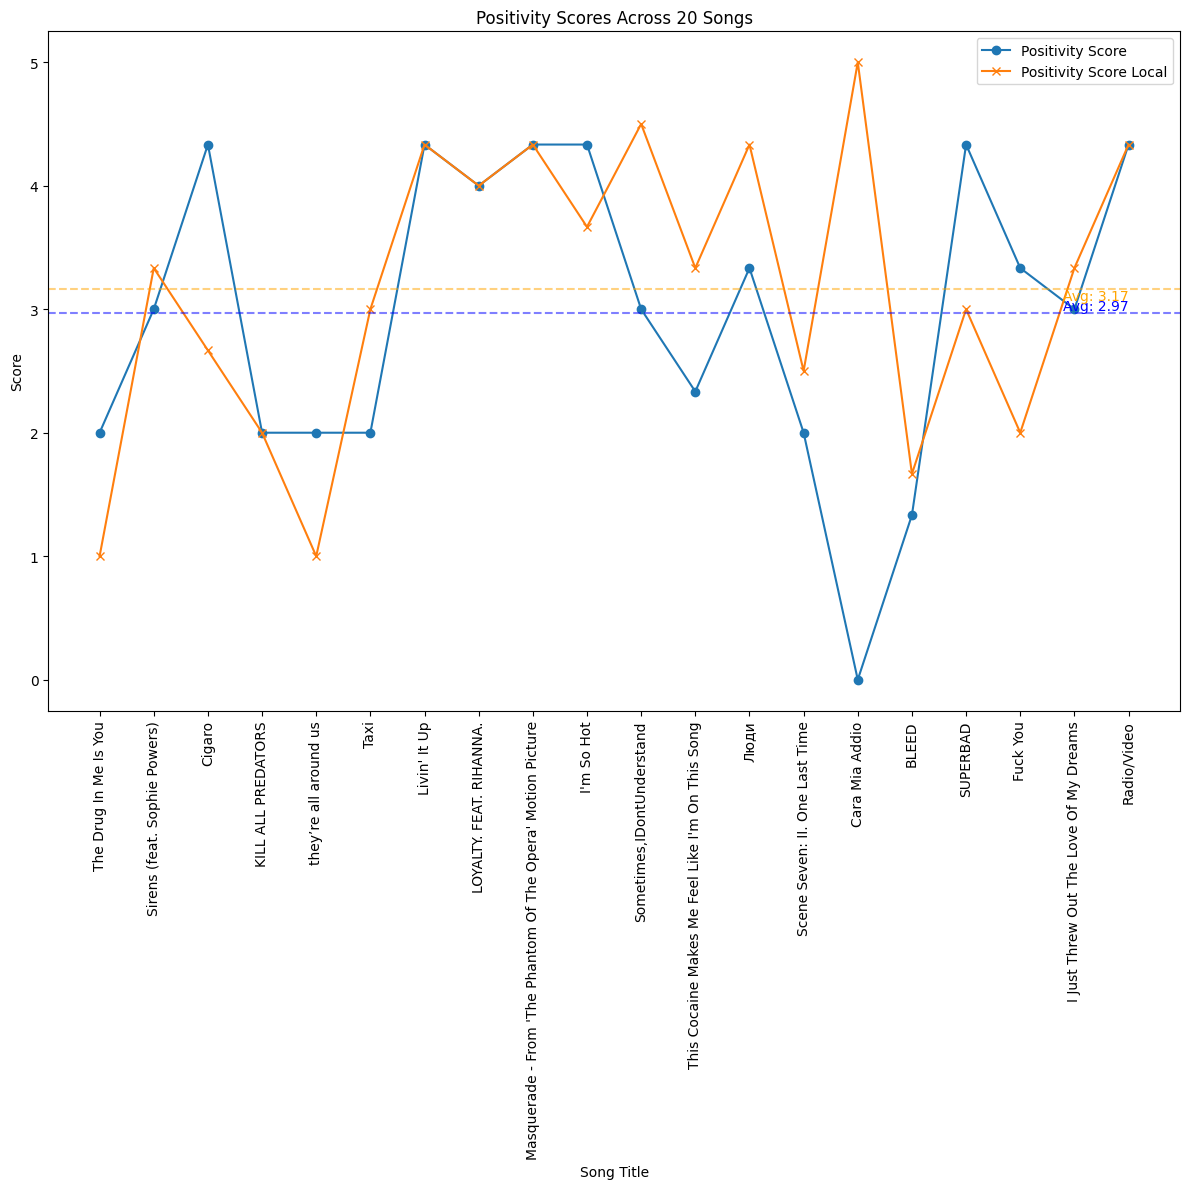

In [ ]:
# ---------------- Plotting the positivity scores, ground truth (analyzed by o3-mini) vs. local LLM (analyzed by Gemma-2B) ----------------
import matplotlib.pyplot as plt

positivity_score = [song['positivity_score'] for song in campare_sample20]
positivity_score_local = [song['positivity_score_local'] for song in campare_sample20]
titles = [song['title'] for song in campare_sample20]

plt.figure(figsize=(12, 12))
plt.plot(titles, positivity_score, marker='o', label='Positivity Score')
plt.plot(titles, positivity_score_local, marker='x', label='Positivity Score Local')
plt.xticks(rotation=90)
plt.xlabel('Song Title')
plt.ylabel('Score')
plt.title('Positivity Scores Across 20 Songs')

avg_positivity = sum(positivity_score) / len(positivity_score)
avg_positivity_local = sum(positivity_score_local) / len(positivity_score_local)

plt.axhline(avg_positivity, color='blue', linestyle='--', alpha=0.5)
plt.axhline(avg_positivity_local, color='orange', linestyle='--', alpha=0.5)

plt.text(len(titles)-1, avg_positivity, f'Avg: {avg_positivity:.2f}', color='blue', va='bottom', ha='right')
plt.text(len(titles)-1, avg_positivity_local, f'Avg: {avg_positivity_local:.2f}', color='orange', va='top', ha='right')

plt.legend()
plt.tight_layout()
plt.show()

In [10]:

campare_sample20

[{'title': 'The Drug In Me Is You',
  'artist': 'Falling In Reverse',
  'mood_tags': ['Dark', 'Melancholic', 'Reflective'],
  'positivity_score': 2.0,
  'mood_tags_local': ['Angry', 'Dark', 'Nostalgia'],
  'positivity_score_local': 1.0},
 {'title': 'Sirens (feat. Sophie Powers)',
  'artist': 'MOTHICA',
  'mood_tags': ['Energetic', 'Dark', 'Passionate'],
  'positivity_score': 3.0,
  'mood_tags_local': ['Energetic', 'Hopeful', 'Dark'],
  'positivity_score_local': 3.3333333333333335},
 {'title': 'Cigaro',
  'artist': 'System Of A Down',
  'mood_tags': ['Energetic', 'Playful', 'Empowering'],
  'positivity_score': 4.333333333333333,
  'mood_tags_local': ['Angry', 'Energetic', 'Bittersweet'],
  'positivity_score_local': 2.6666666666666665},
 {'title': 'KILL ALL PREDATORS',
  'artist': 'Banshee',
  'mood_tags': ['Angry', 'Dark', 'Energetic'],
  'positivity_score': 2.0,
  'mood_tags_local': ['Angry', 'Dark', 'Energetic'],
  'positivity_score_local': 2.0},
 {'title': 'they’re all around us',
  